With the csv file Example & on dataset 2


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Define Labels

In [3]:
labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented','Very_Mild_Demented']

In [4]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Dataset',  i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)



# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)

100%|██████████| 2240/2240 [00:29<00:00, 75.94it/s] 


In [5]:
Xtrain.shape

(6400, 150, 150, 3)

In [6]:
Ytrain.shape

(6400,)

In [7]:
Xtrain,Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

## Train test split which is divided train dataset and validation dataset

In [8]:
xtrain,xtest, ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.3, random_state=42)

In [9]:
xtrain.shape

(4480, 150, 150, 3)

In [ ]:
ytrain.shape

(4480,)

In [10]:
xtest.shape

(1920, 150, 150, 3)

In [11]:
ytest.shape

(1920,)

## Converting labels into One hot encoder

In [12]:
ytrain_new = []
ytest_new = []

for i in ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e

ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [15]:
ytrain.shape

(4480, 4)

In [16]:
ytest.shape

(1920, 4)

# DENSENET MODEL

In [17]:
image_size = 150

In [18]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(image_size, image_size, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [19]:
# Output of model

model = model_d.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=model_d.input, outputs=model)

In [20]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

In [21]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [22]:
history=model.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

Epoch 1/50
140/140 [==============================] - 116s 205ms/step - loss: 1.0215 - accuracy: 0.7988 - precision: 0.6129 - recall: 0.5301 - auc: 0.8435 - val_loss: 7.0478 - val_accuracy: 0.6771 - val_precision: 0.3542 - val_recall: 0.3542 - val_auc: 0.6139
Epoch 2/50
140/140 [==============================] - 29s 209ms/step - loss: 0.7005 - accuracy: 0.8617 - precision: 0.7519 - recall: 0.6670 - auc: 0.9162 - val_loss: 1000.9305 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.6667
Epoch 3/50
140/140 [==============================] - 29s 209ms/step - loss: 0.4467 - accuracy: 0.9126 - precision: 0.8406 - recall: 0.8027 - auc: 0.9642 - val_loss: 1.0165 - val_accuracy: 0.7733 - val_precision: 0.5514 - val_recall: 0.5000 - val_auc: 0.8420
Epoch 4/50
140/140 [==============================] - 27s 191ms/step - loss: 0.3087 - accuracy: 0.9430 - precision: 0.8955 - recall: 0.8739 - auc: 0.9814 - val_loss: 2.5770 - val_accuracy: 0.8448 - val_precision: 0.6918

In [25]:
metrics = pd.DataFrame(model.history.history)

In [24]:
import pandas as pd


In [27]:
metrics.to_csv('/content/sample_data/Dense.csv', index=False)
model.save('/content/sample_data/dense_final.h5')
model.save('/content/sample_data/dense_final.pkl')

In [28]:
labels_final = ['Mild_Demented1', 'Moderate_Demented1', 'Non_Demented1','Very_Mild_Demented1']

In [29]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred , target_names = labels))

60/60 [==============================] - 5s 45ms/step
                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.93      0.96       276
 Moderate_Demented       1.00      0.63      0.77        19
      Non_Demented       0.99      0.98      0.98       960
Very_Mild_Demented       0.94      0.98      0.96       665

          accuracy                           0.97      1920
         macro avg       0.98      0.88      0.92      1920
      weighted avg       0.97      0.97      0.97      1920



In [30]:
accuracy_score(actual_label, pred)

0.9713541666666666

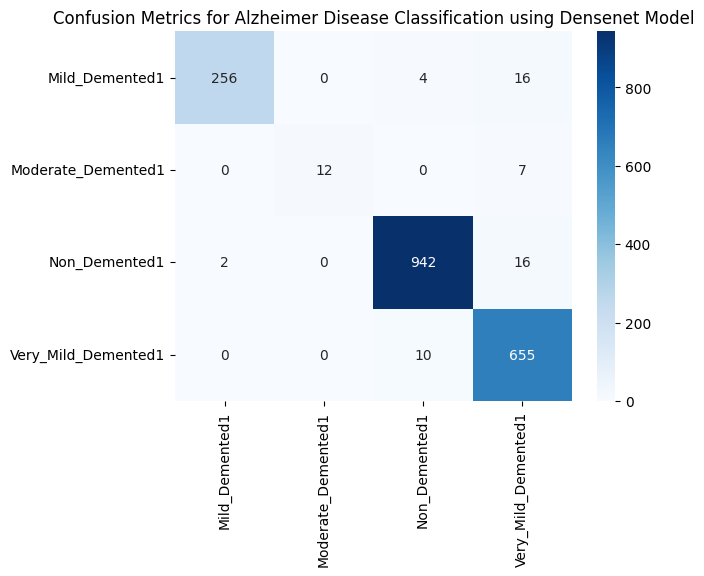

In [31]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Densenet Model")
plt.savefig('densenet_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement graph

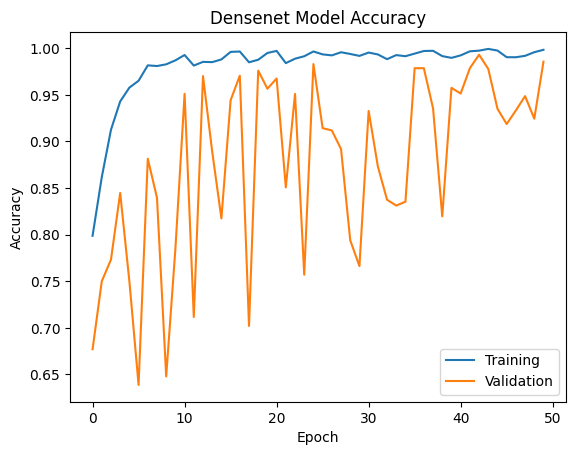

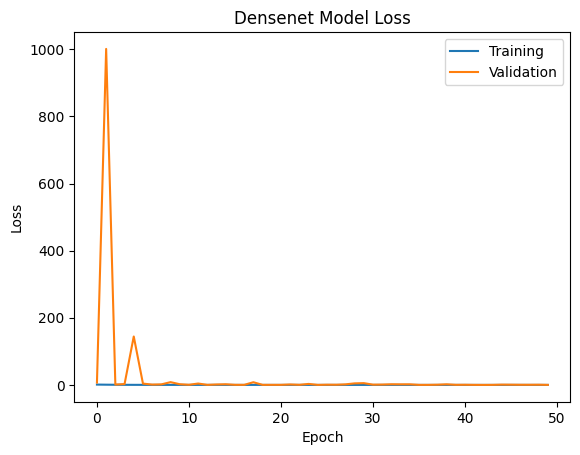

In [32]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Densenet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Densenet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_loss.png', dpi=300) # Save plot as PNG
plt.show()

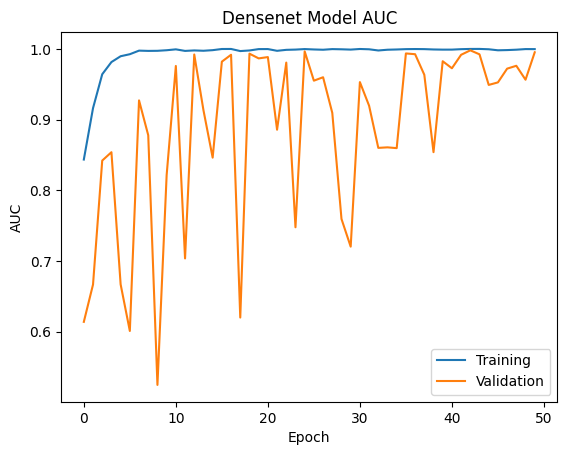

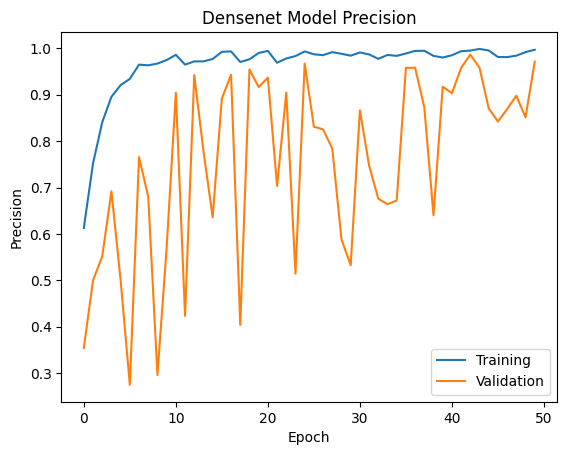

In [33]:
# Plot the training and validation auc
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Densenet Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Densenet Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('densenet_precision.png', dpi=300) # Save plot as PNG
plt.show()

## CNN MODEL

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers

model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers

model16 = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [35]:
#Create the model
cnn=Sequential()
#initially 64 convolution nodes
cnn.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=(image_size, image_size, 3)))
#add a Max Pooling layer
cnn.add(MaxPooling2D())
#another 32 convolution nodes
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Add 32 convolutions
cnn.add(Conv2D(32,(2,2),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Flatten before adding fully connected layer
cnn.add(Flatten())
#Add a hidden layer with 100 nodes
cnn.add(Dense(100,activation='relu'))
#Add another hidden layer with 50 nodes
cnn.add(Dense(50,activation='relu'))
#Add final output layer with 4 output nodes using softmax
cnn.add(Dense(4,activation='softmax'))

In [36]:
cnn.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
model1.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

In [38]:
history1=cnn.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

Epoch 1/50
140/140 [==============================] - 8s 32ms/step - loss: 2.7975 - accuracy: 0.8384 - precision: 0.7227 - recall: 0.5734 - auc: 0.8810 - val_loss: 0.8660 - val_accuracy: 0.8116 - val_precision: 0.6890 - val_recall: 0.4490 - val_auc: 0.8612
Epoch 2/50
140/140 [==============================] - 4s 27ms/step - loss: 0.8074 - accuracy: 0.8272 - precision: 0.6997 - recall: 0.5413 - auc: 0.8813 - val_loss: 0.9326 - val_accuracy: 0.8076 - val_precision: 0.6202 - val_recall: 0.5938 - val_auc: 0.8591
Epoch 3/50
140/140 [==============================] - 3s 25ms/step - loss: 0.7264 - accuracy: 0.8416 - precision: 0.7215 - recall: 0.5967 - auc: 0.9035 - val_loss: 0.7899 - val_accuracy: 0.8306 - val_precision: 0.6707 - val_recall: 0.6333 - val_auc: 0.8926
Epoch 4/50
140/140 [==============================] - 3s 25ms/step - loss: 0.6540 - accuracy: 0.8584 - precision: 0.7450 - recall: 0.6594 - auc: 0.9220 - val_loss: 0.6522 - val_accuracy: 0.8551 - val_precision: 0.7261 - val_recal

In [49]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history1.history)

# Save the training history to a CSV file
metrics.to_csv('/content/sample_data/CNN.csv', index=False)

# Save the model itself
model.save('/content/sample_data/CNN.h5')


In [50]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 32)        4128      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 32)      

In [52]:
pred1 = cnn.predict(xtest)
pred1 = np.argmax(pred1, axis=1)
actual_label1 = np.argmax(ytest, axis=1)
print(classification_report(actual_label1, pred1 , target_names = labels_final))

60/60 [==============================] - 0s 7ms/step
                     precision    recall  f1-score   support

     Mild_Demented1       0.97      0.86      0.91       276
 Moderate_Demented1       1.00      0.79      0.88        19
      Non_Demented1       0.99      0.91      0.95       960
Very_Mild_Demented1       0.84      0.98      0.91       665

           accuracy                           0.93      1920
          macro avg       0.95      0.88      0.91      1920
       weighted avg       0.93      0.93      0.93      1920



In [ ]:
pred1 = model1.predict(xtest)
pred1 = np.argmax(pred1, axis=1)
actual_label1 = np.argmax(ytest, axis=1)
print(classification_report(actual_label1, pred1 , target_names = labels_final))

177/177 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

          AD       0.95      0.89      0.92      2481
          CN       0.89      0.97      0.93      2603
        EMCI       0.77      0.63      0.69       130
        LMCI       1.00      0.65      0.79        43
         MCI       0.86      0.71      0.78       376

    accuracy                           0.91      5633
   macro avg       0.89      0.77      0.82      5633
weighted avg       0.91      0.91      0.91      5633



In [53]:
accuracy_score(actual_label1, pred1)

0.9260416666666667

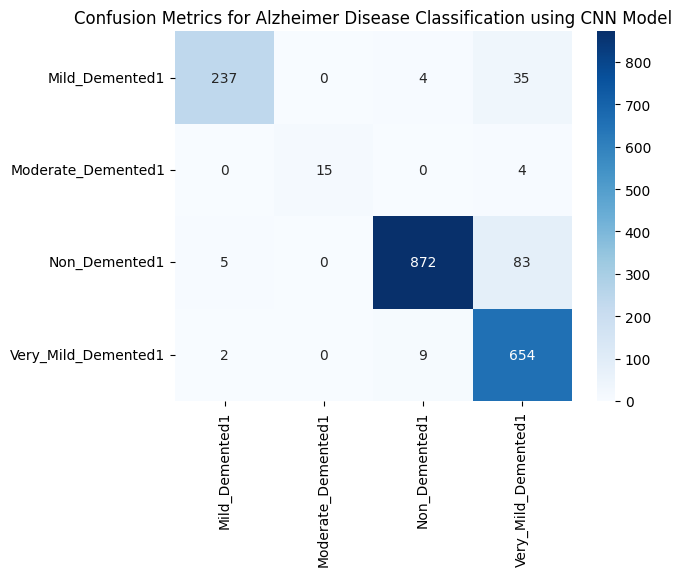

In [54]:
Cm1=confusion_matrix(actual_label1,pred1)
ax1=plt.axes()
sns.heatmap(Cm1, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax1
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using CNN Model")
plt.savefig('cnn_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - CNN Model

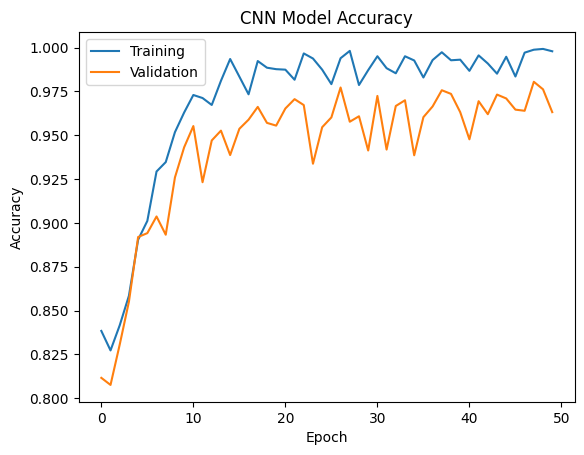

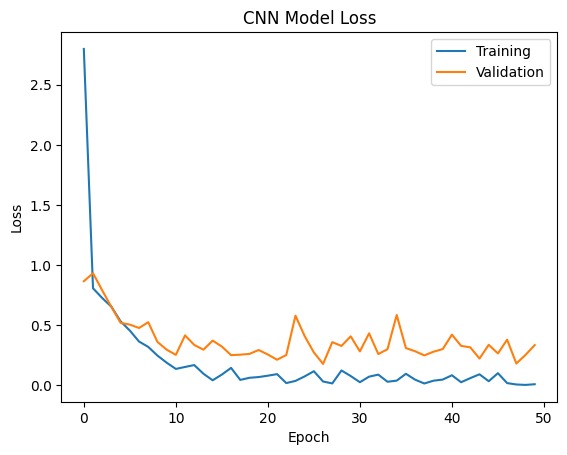

In [55]:
# Plot the training and validation accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_loss.png', dpi=300) # Save plot as PNG
plt.show()

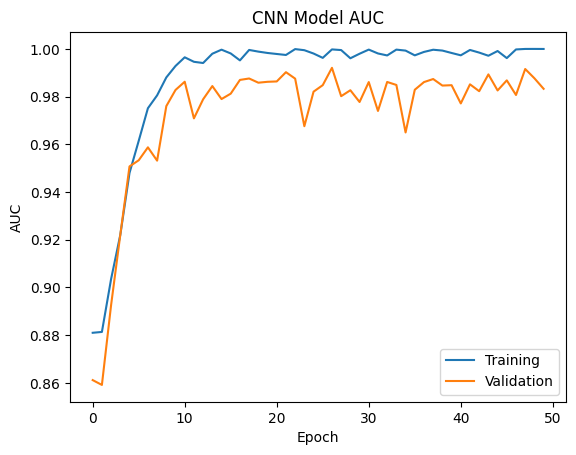

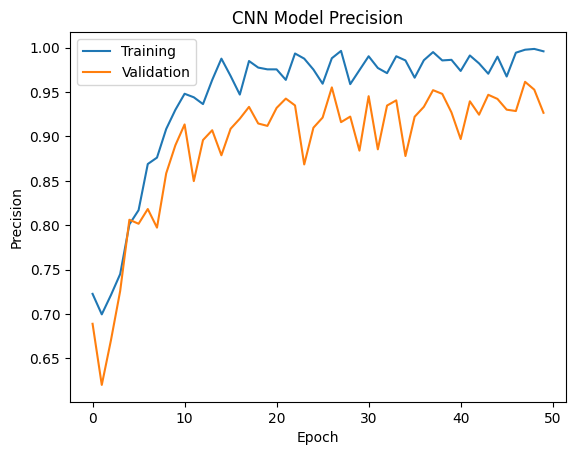

In [56]:
# Plot the training and validation auc
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.title('CNN Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history1.history['precision'])
plt.plot(history1.history['val_precision'])
plt.title('CNN Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Efficient NetB7 Model

In [57]:
from tensorflow.keras.applications import EfficientNetB7

In [58]:
efficientnetB7= EfficientNetB7(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

258076736/258076736 [==============================] - 5s 0us/step


In [59]:
# Output of model

model2 = efficientnetB7.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.5)(model2)
model2 = tf.keras.layers.Dense(4, activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=efficientnetB7.input, outputs=model2)

In [60]:
model2.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [61]:
history2=model2.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

Epoch 1/50
140/140 [==============================] - 292s 975ms/step - loss: 0.8404 - accuracy: 0.8654 - precision: 0.7766 - recall: 0.6480 - auc: 0.9228 - val_loss: 2.6638 - val_accuracy: 0.7717 - val_precision: 0.5435 - val_recall: 0.5432 - val_auc: 0.7748
Epoch 2/50
140/140 [==============================] - 130s 931ms/step - loss: 0.4450 - accuracy: 0.9181 - precision: 0.8534 - recall: 0.8118 - auc: 0.9645 - val_loss: 1.2646 - val_accuracy: 0.8712 - val_precision: 0.7438 - val_recall: 0.7396 - val_auc: 0.9013
Epoch 3/50
140/140 [==============================] - 120s 861ms/step - loss: 0.2061 - accuracy: 0.9633 - precision: 0.9314 - recall: 0.9212 - auc: 0.9910 - val_loss: 0.2658 - val_accuracy: 0.9493 - val_precision: 0.9044 - val_recall: 0.8917 - val_auc: 0.9862
Epoch 4/50
140/140 [==============================] - 130s 932ms/step - loss: 0.1249 - accuracy: 0.9782 - precision: 0.9591 - recall: 0.9536 - auc: 0.9963 - val_loss: 0.2828 - val_accuracy: 0.9612 - val_precision: 0.9242

KeyboardInterrupt: ignored

In [ ]:
history2 = model2.load_weights('/content/drive/MyDrive/efficientb7.h5')

ValueError: ignored

In [ ]:
import pickle

with open('/content/drive/MyDrive/efficientb7_history.pkl', 'rb') as f:
    history2 = pickle.load(f)


In [ ]:
pred2 = model2.predict(xtest)
pred2 = np.argmax(pred2, axis=1)
actual_label2 = np.argmax(ytest, axis=1)
print(classification_report(actual_label2, pred2,target_names = labels_final))

177/177 [==============================] - 28s 124ms/step
              precision    recall  f1-score   support

          AD       0.96      0.97      0.97      2481
          CN       0.97      0.98      0.97      2603
        EMCI       0.77      0.72      0.75       130
        LMCI       0.67      0.65      0.66        43
         MCI       0.82      0.73      0.77       376

    accuracy                           0.95      5633
   macro avg       0.84      0.81      0.82      5633
weighted avg       0.95      0.95      0.95      5633



In [ ]:
accuracy_score(actual_label2, pred2)

0.9515355938221196

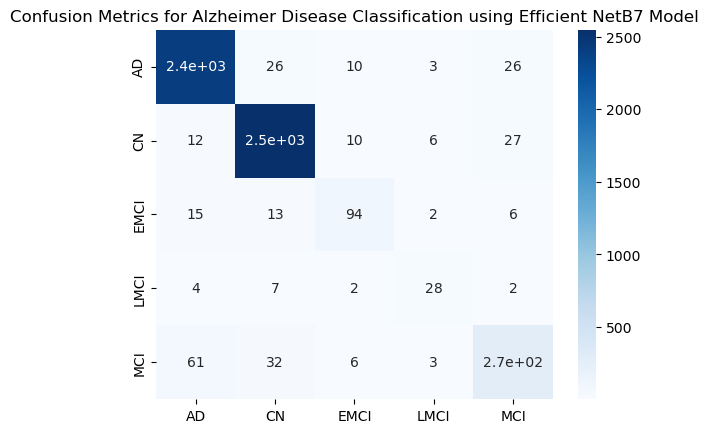

In [ ]:
Cm2=confusion_matrix(actual_label2,pred2)
ax2=plt.axes()
sns.heatmap(Cm2, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax2
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Efficient NetB7 Model")
plt.savefig('netb7_confusion.png', dpi=300) # Save plot as PNG
plt.show()

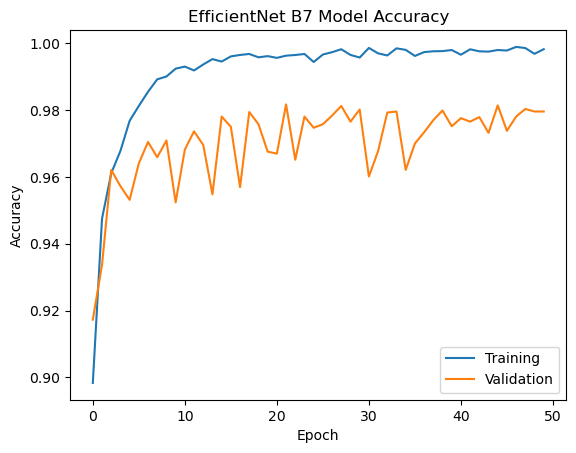

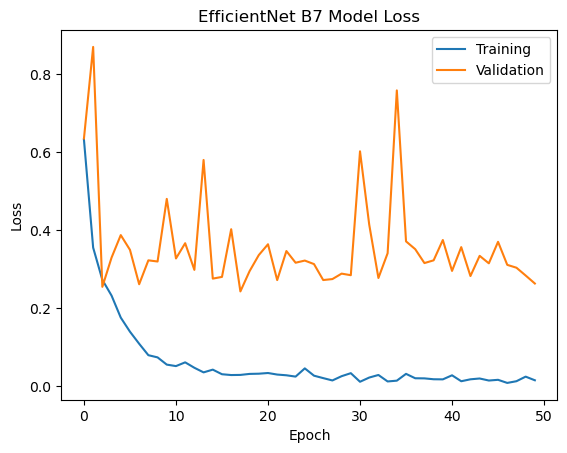

In [ ]:
# Plot the training and validation accuracy
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('EfficientNet B7 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('EfficientNet B7 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_loss.png', dpi=300) # Save plot as PNG
plt.show()

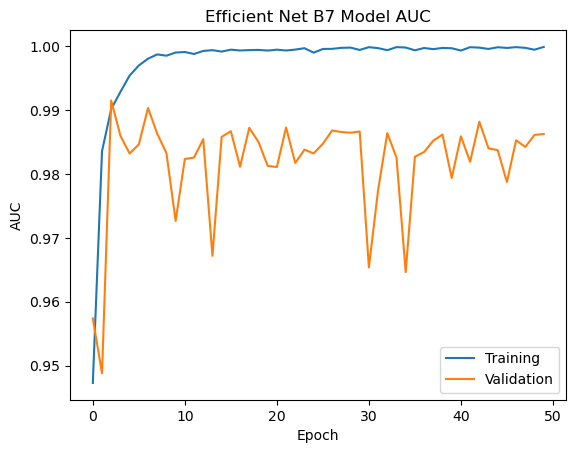

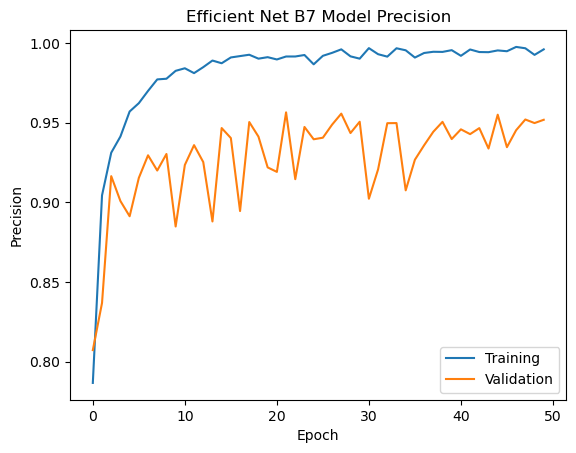

In [ ]:
# Plot the training and validation auc
plt.plot(history2['auc'])
plt.plot(history2['val_auc'])
plt.title('Efficient Net B7 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_auc.png', dpi=300) # Save plot as PNG

plt.show()

# Plot the training and validation precision
plt.plot(history2['precision'])
plt.plot(history2['val_precision'])
plt.title('Efficient Net B7 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('netb7_precision.png', dpi=300) # Save plot as PNG
plt.show()

# VGG19 MODEL

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights='imagenet',
            include_top = False,input_shape=(image_size, image_size, 3)
           )
for layer in vgg.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model3 = Sequential()
model3.add(vgg)
model3.add(Flatten())
model3.add(Dense(5,activation="softmax"))
#model.summary()

80134624/80134624 [==============================] - 1s 0us/step


## Compile VGG19 Model

In [ ]:
model3.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
history3 = model3.load_weights('/kaggle/input/model-training/Model Training/vgg19.h5')

In [ ]:
import pickle

with open('/kaggle/input/model-training/Model Training/vgg19_history.pkl', 'rb') as f:
    history3 = pickle.load(f)


In [ ]:
pred3 = model3.predict(xtest)
pred3 = np.argmax(pred3, axis=1)
actual_label3 = np.argmax(ytest, axis=1)
print(classification_report(actual_label3, pred3, target_names = labels_final))

177/177 [==============================] - 8s 38ms/step
              precision    recall  f1-score   support

          AD       0.80      0.95      0.87      2481
          CN       0.94      0.82      0.88      2603
        EMCI       0.74      0.62      0.67       130
        LMCI       0.67      0.65      0.66        43
         MCI       0.83      0.57      0.68       376

    accuracy                           0.86      5633
   macro avg       0.80      0.72      0.75      5633
weighted avg       0.86      0.86      0.85      5633



In [ ]:
accuracy_score(actual_label3, pred3)

0.8554944079531334

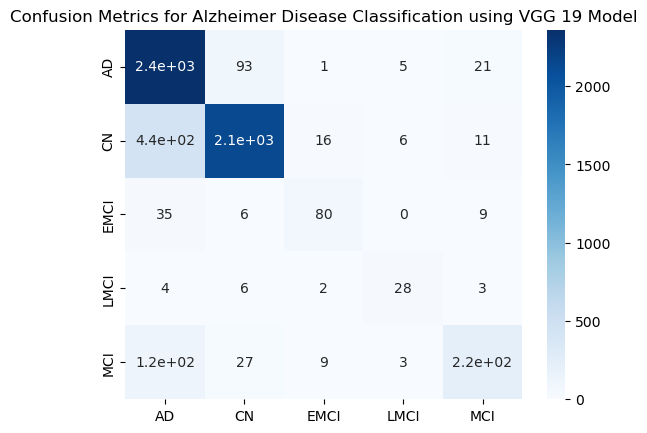

In [ ]:
Cm3=confusion_matrix(actual_label3,pred3)
ax3=plt.axes()
sns.heatmap(Cm3, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using VGG 19 Model")
plt.savefig('vgg19_confusion.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement Graph - VGG19 Model

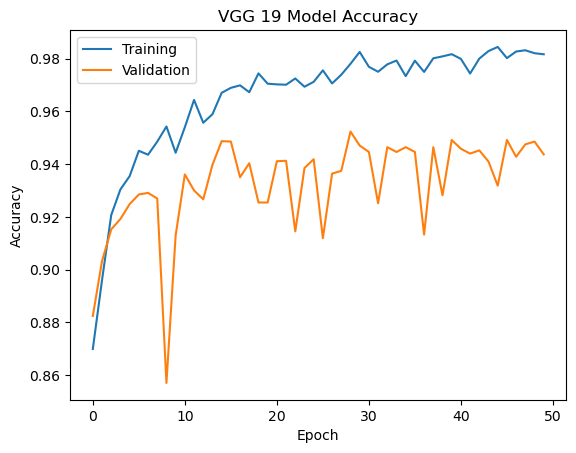

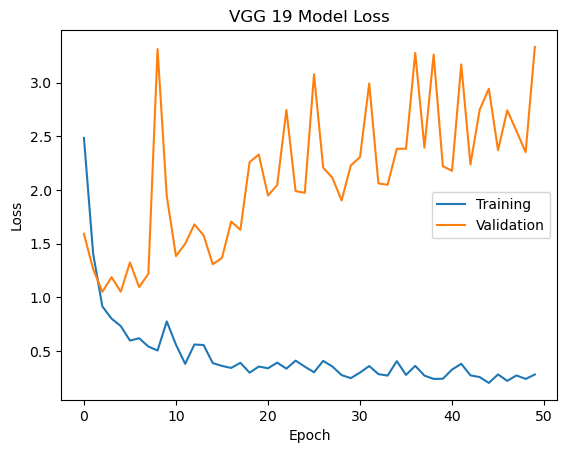

In [ ]:
# Plot the training and validation accuracy
plt.plot(history3['accuracy'])
plt.plot(history3['val_accuracy'])
plt.title('VGG 19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history3['loss'])
plt.plot(history3['val_loss'])
plt.title('VGG 19 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_loss.png', dpi=300) # Save plot as PNG
plt.show()

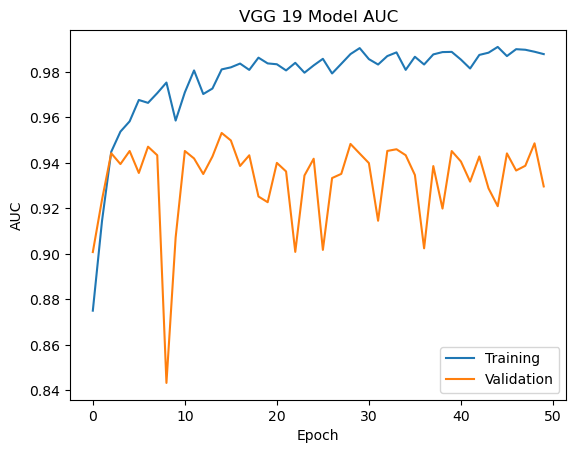

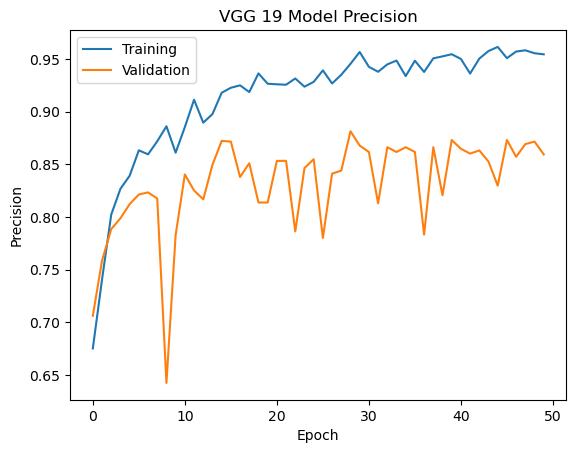

In [ ]:
# Plot the training and validation auc
plt.plot(history3['auc'])
plt.plot(history3['val_auc'])
plt.title('VGG 19 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history3['precision'])
plt.plot(history3['val_precision'])
plt.title('VGG 19 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_precision.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
rn = ResNet50(input_shape=(150,150,3), weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
for layer in rn.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model4 = Sequential()
model4.add(rn)
model4.add(Flatten())
model4.add(Dense(4,activation="softmax"))

In [ ]:
model4.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [ ]:
history4=model4.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

Epoch 1/50
140/140 [==============================] - 11s 82ms/step - loss: 3.0889 - accuracy: 0.7965 - precision: 0.5949 - recall: 0.5828 - auc: 0.8129 - val_loss: 1.5663 - val_accuracy: 0.8143 - val_precision: 0.6318 - val_recall: 0.6167 - val_auc: 0.8473
Epoch 2/50
140/140 [==============================] - 12s 88ms/step - loss: 0.9109 - accuracy: 0.8741 - precision: 0.7519 - recall: 0.7408 - auc: 0.9195 - val_loss: 0.6993 - val_accuracy: 0.8862 - val_precision: 0.7788 - val_recall: 0.7609 - val_auc: 0.9345
Epoch 3/50
140/140 [==============================] - 10s 73ms/step - loss: 0.5407 - accuracy: 0.9166 - precision: 0.8362 - recall: 0.8286 - auc: 0.9608 - val_loss: 0.9959 - val_accuracy: 0.8540 - val_precision: 0.7117 - val_recall: 0.6995 - val_auc: 0.9058
Epoch 4/50
140/140 [==============================] - 12s 88ms/step - loss: 0.2868 - accuracy: 0.9489 - precision: 0.9010 - recall: 0.8940 - auc: 0.9847 - val_loss: 2.2871 - val_accuracy: 0.7822 - val_precision: 0.5648 - val_r

In [ ]:
pred4 = model4.predict(xtest)
pred3 = np.argmax(pred4, axis=1)
actual_label3 = np.argmax(ytest, axis=1)
print(classification_report(actual_label3, pred3, target_names = labels_final))

60/60 [==============================] - 4s 50ms/step
                     precision    recall  f1-score   support

     Mild_Demented1       0.97      0.88      0.92       276
 Moderate_Demented1       1.00      0.79      0.88        19
      Non_Demented1       0.95      0.96      0.96       960
Very_Mild_Demented1       0.91      0.94      0.92       665

           accuracy                           0.94      1920
          macro avg       0.96      0.89      0.92      1920
       weighted avg       0.94      0.94      0.94      1920



## Comparison and Graphs of Different Model Types

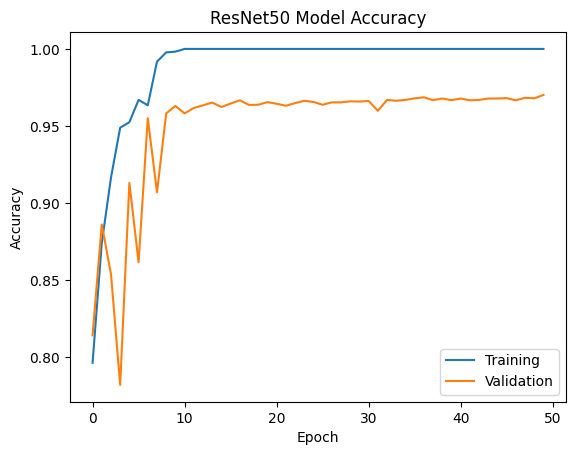

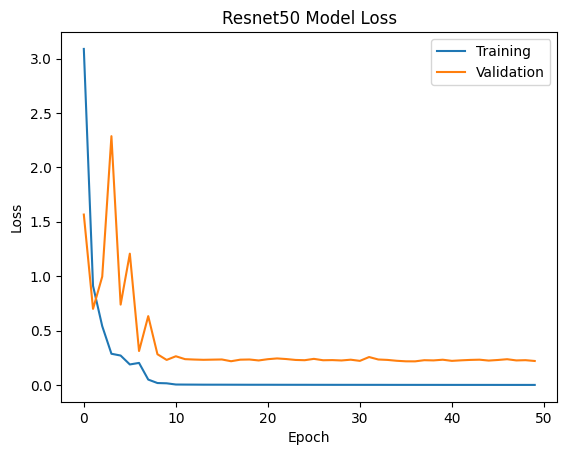

In [ ]:
# Plot the training and validation accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('Resnet50_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Resnet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('resnet_loss.png', dpi=300) # Save plot as PNG
plt.show()

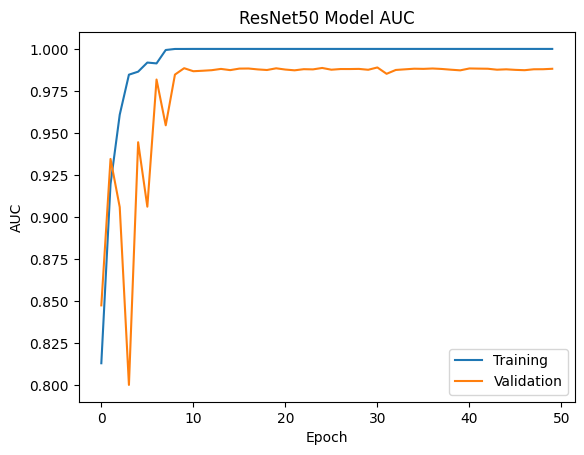

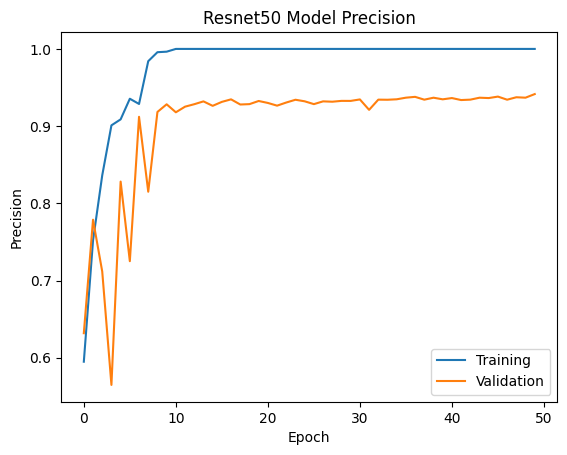

In [ ]:
# Plot the training and validation auc
plt.plot(history4.history['auc'])
plt.plot(history4.history['val_auc'])
plt.title('ResNet50 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history4.history['precision'])
plt.plot(history4.history['val_precision'])
plt.title('Resnet50 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('vgg19_precision.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
scores  = model.evaluate(xtest, ytest, verbose=1)
scores1 = cnn.evaluate(xtest, ytest, verbose=1)
scores2 = model4.evaluate(xtest, ytest, verbose=1)
#scores3 = model3.evaluate(xtest, ytest, verbose=1)


60/60 [==============================] - 3s 51ms/step - loss: 0.2204 - accuracy: 0.9702 - precision: 0.9415 - recall: 0.9391 - auc: 0.9882


## Densenet

In [ ]:
precision = scores[0]
f1_score = scores[1]
recall = scores[2]
accuracy = scores[3]

## CNN

In [ ]:
precision1 = scores1[0]
f1_score1 = scores1[1]
recall1 = scores1[2]
accuracy1 = scores1[3]

## Efficient Net B7

In [ ]:
precision2 = scores2[0]
f1_score2 = scores2[1]
recall2 = scores2[2]
accuracy2 = scores2[3]

## VGG 19

In [ ]:
precision3 = scores3[0]
f1_score3 = scores3[1]
recall3 = scores3[2]
accuracy3 = scores3[3]

In [ ]:
import pandas as pd

eval_df = pd.DataFrame(columns=['Model','Precision', 'F1 Score', 'Recall', 'Accuracy'])


In [ ]:
eval_df = eval_df.append({'Model' : 'Densenet', 'Precision': precision, 'F1 Score': f1_score, 'Recall': recall, 'Accuracy': accuracy}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'CNN', 'Precision': precision1, 'F1 Score': f1_score1, 'Recall': recall1, 'Accuracy': accuracy1}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'ResNet50', 'Precision': precision2, 'F1 Score': f1_score2, 'Recall': recall2, 'Accuracy': accuracy2}, ignore_index=True)
#eval_df = eval_df.append({'Model' : 'VGG 19', 'Precision': precision3, 'F1 Score': f1_score3, 'Recall': recall3, 'Accuracy': accuracy3}, ignore_index=True)


In [ ]:
eval_df

,Model,Precision,F1 Score,Recall,Accuracy
0,Densenet,0.238398,0.968880,0.939822,0.935417
1,CNN,0.359487,0.960286,0.921231,0.919792
2,ResNet50,0.220427,0.970182,0.941514,0.939062


In [ ]:
import csv
eval_df.to_csv('comparison_metrics.csv', index=False)

## Ensemble Learning

In [ ]:
pred = model.predict(xtest)
pred1=cnn.predict(xtest)
pred2 = model4.predict(xtest)
#pred3=model3.predict(xtest)
ensemble_preds = np.average([pred, pred1 ,pred2], axis=0)
final_preds = np.argmax(ensemble_preds, axis=1)
actual_label_final = np.argmax(ytest, axis=1)
print(classification_report(actual_label_final, final_preds,target_names = labels_final))

60/60 [==============================] - 3s 47ms/step
                     precision    recall  f1-score   support

     Mild_Demented1       0.96      0.98      0.97       276
 Moderate_Demented1       1.00      0.95      0.97        19
      Non_Demented1       0.99      0.97      0.98       960
Very_Mild_Demented1       0.96      0.99      0.97       665

           accuracy                           0.98      1920
          macro avg       0.98      0.97      0.98      1920
       weighted avg       0.98      0.98      0.98      1920



In [ ]:
history5=

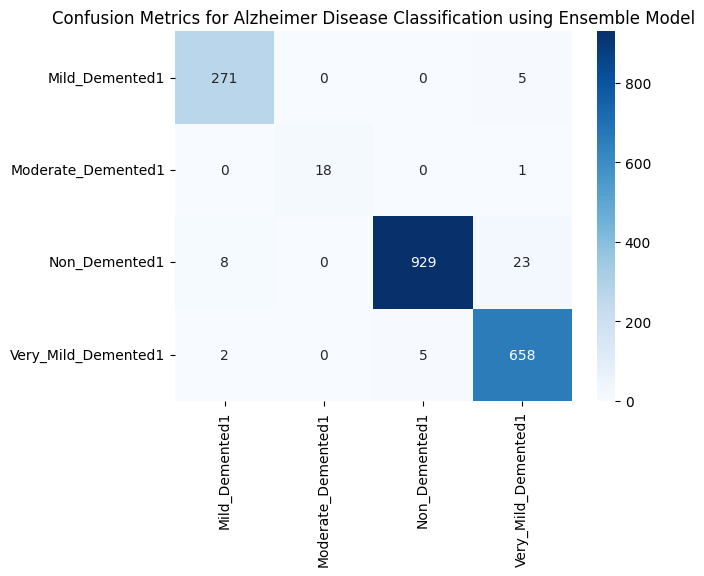

In [ ]:
Cm4=confusion_matrix(actual_label_final,final_preds)
ax3=plt.axes()
sns.heatmap(Cm4, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_final,
           yticklabels=labels_final,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Ensemble Model")
plt.savefig('ensemble_confusion.png', dpi=300) # Save plot as PNG
plt.show()

In [ ]:
ensemble_preds.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

AttributeError: ignored

In [ ]:
import pickle
with open('/kaggle/input/model-training/Model Training/ensemble_history.pkl', 'rb') as f:
    final = pickle.load(f)

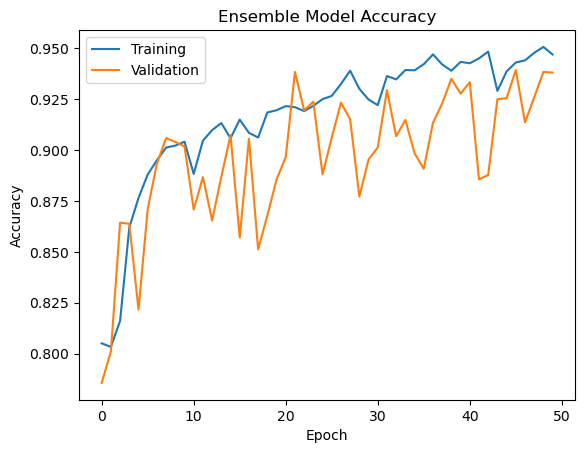

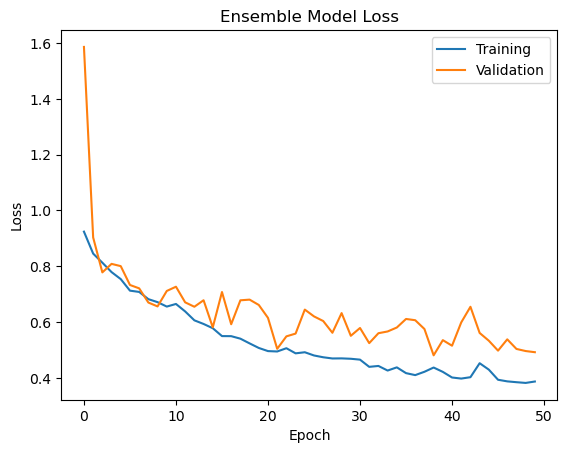

In [ ]:
# Plot the training and validation accuracy
plt.plot(final['accuracy'])
plt.plot(final['val_accuracy'])
plt.title('Ensemble Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_accuracy2.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(final['loss'])
plt.plot(final['val_loss'])
plt.title('Ensemble Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_loss2.png', dpi=300) # Save plot as PNG
plt.show()

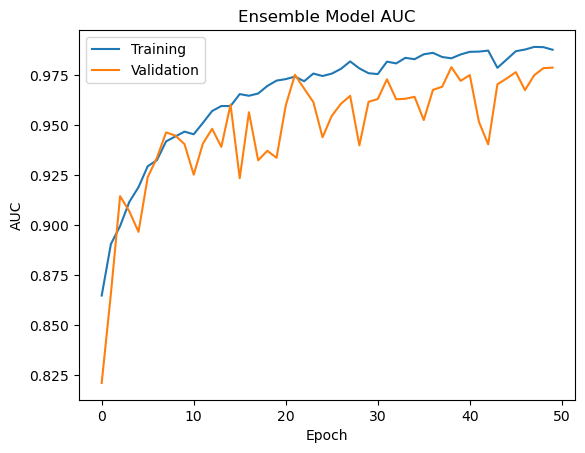

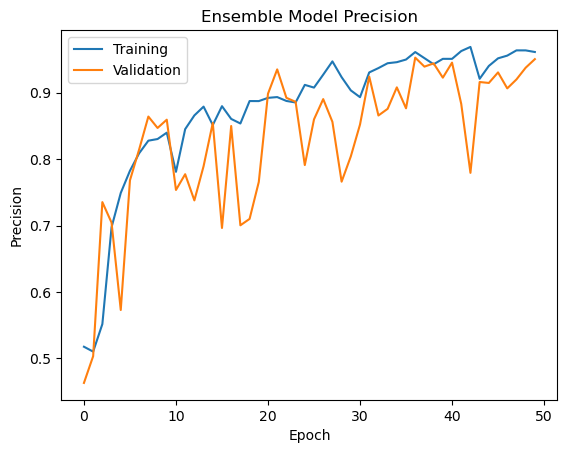

In [ ]:
# Plot the training and validation auc
plt.plot(final['auc'])
plt.plot(final['val_auc'])
plt.title('Ensemble Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_auc2.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(final['precision'])
plt.plot(final['val_precision'])
plt.title('Ensemble Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('ensemble_precision2.png', dpi=300) # Save plot as PNG
plt.show()

## Mean Square Error

In [ ]:
from sklearn.metrics import mean_squared_error

pred_final1 = (pred + pred1 + pred2 + pred3)/4.0

# printing the mean squared error between real value and predicted value
print(mean_squared_error(ytest, pred_final1))

0.014353122


## Prediction

In [ ]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))

    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model2.predict(images)
    prd = np.argmax(prd, axis = 1)[0]


    if prd == 0:
        prd = "Final AD JPEG"
    elif prd == 1:
        prd = "Final CN JPEG"
    elif prd == 2:
        prd = "Final EMCI JPEG"
    elif prd == 3:
        prd = "Final LMCI JPEG"
    elif prd == 4:
        prd = "Final MCI JPEG"
    if prd!=1:
        print(f'Model Predict That is  a {prd}')


In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")


button.on_click(on_button_click)
widgets.VBox([button, out])
